In [1]:
# Import packages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pylab import rcParams
rcParams['figure.figsize'] = 16, 7

In [2]:
# Import data
rye = pd.read_csv('rye.csv', parse_dates=['date'], index_col='date')
rye.dropna(inplace=True)

rye.head()

,open,high,low,close,volume
date,,,,,
2006-11-07,38.423952,38.423952,38.082817,38.082817,18000
2006-11-08,38.082817,38.082817,38.082817,38.082817,0
2006-11-09,39.424061,39.424061,39.424061,39.424061,1000
2006-11-10,38.803834,38.803834,38.648773,38.648773,400
2006-11-13,38.648773,38.648773,38.648773,38.648773,0


In [3]:
# Define functions

## Plot time series
def plot_df(x, y, title='', xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16, 7), dpi=dpi)
    plt.plot(x, y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

## Plot probability density
def plot_kde(x, title='', xlabel='', ylabel='', dpi=100):
    plt.figure(figsize=(16, 7), dpi=dpi)
    x.plot(kind='kde')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

## Test and plot stationarity
def test_stationarity(timeseries, title='Rolling Mean and Standard Deviation', xlabel='', ylabel='', dpi=100):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # Plot rolling statistics:
    plt.figure(figsize=(16, 7), dpi=dpi)
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Std')
    plt.legend(loc='best')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show(block=False)
    
    # Print rolling statistics
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

## Plot seasonality
def plot_seasonality(x, title='Seasonality Analysis'):
    result = seasonal_decompose(x, model='multiplicative', period=30)
    result.plot().set_size_inches(16, 7)

## Plot moving average and standard deviation
def plot_masd(moving_avg, std_dev, title='Moving Average and Standard Deviation', xlabel='Date', ylabel='Log Value', dpi=100):
    plt.figure(figsize=(16, 7), dpi=dpi)
    plt.plot(std_dev, label = "Standard Deviation")
    plt.plot(moving_avg, label = "Mean")
    plt.legend(loc='best')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show(block=False)
    
## Plot train and test split
def plot_split(complete, test, title='Data Split - Train and Test', xlabel='Date', ylabel='Log Value', dpi=100):
    plt.figure(figsize=(16, 7), dpi=dpi)
    plt.plot(complete, label='Train data')
    plt.plot(test, label='Test data')
    plt.legend(loc='best')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show(block=False)
    
## Plot forecast
def plot_forecast(train, test, res, title='RYE Index Price Forecast', xlabel='Date', ylabel='Log Value', dpi=100):
    plt.figure(figsize=(16, 7), dpi=dpi)
    plt.plot(train, label='Train data')
    plt.plot(test, label='Test data - Actual index price')
    plt.plot(res['predicted_mean'], label='Predicted index price')
    plt.fill_between(res.index, res['lower close'], res['upper close'], color='black', alpha=.1)
    plt.legend(loc='best')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show(block=False)

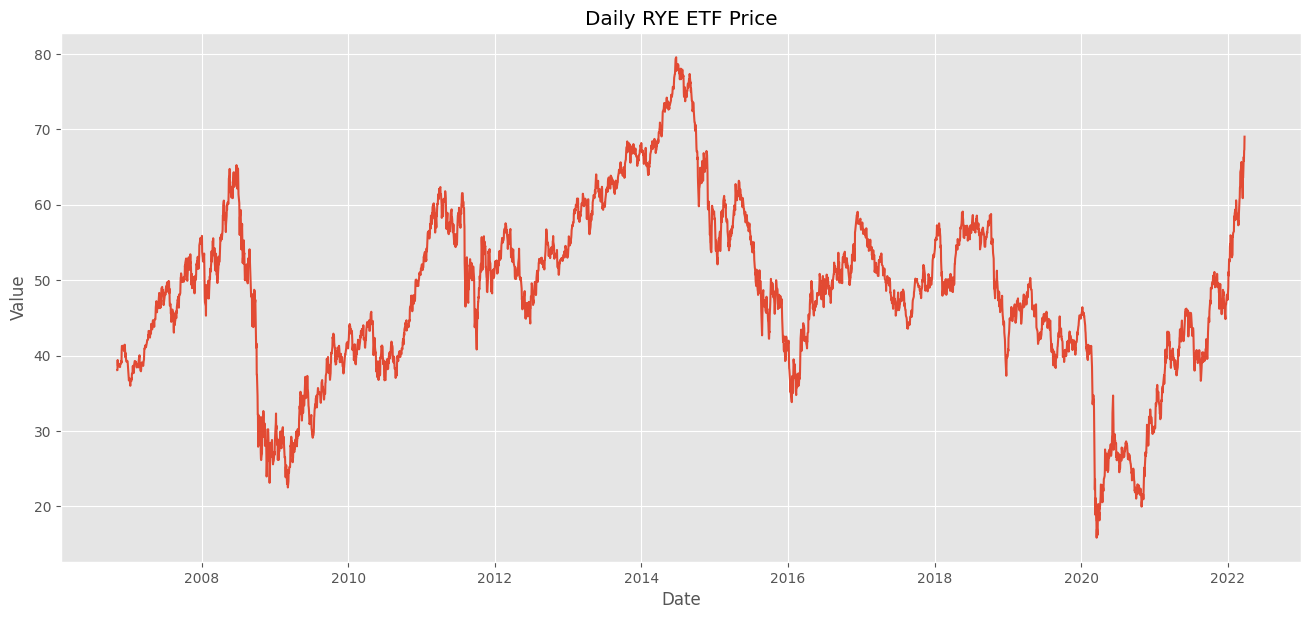

In [4]:
# Plot daily index price
plot_df(x=rye.index, y=rye['close'], title='Daily RYE ETF Price')

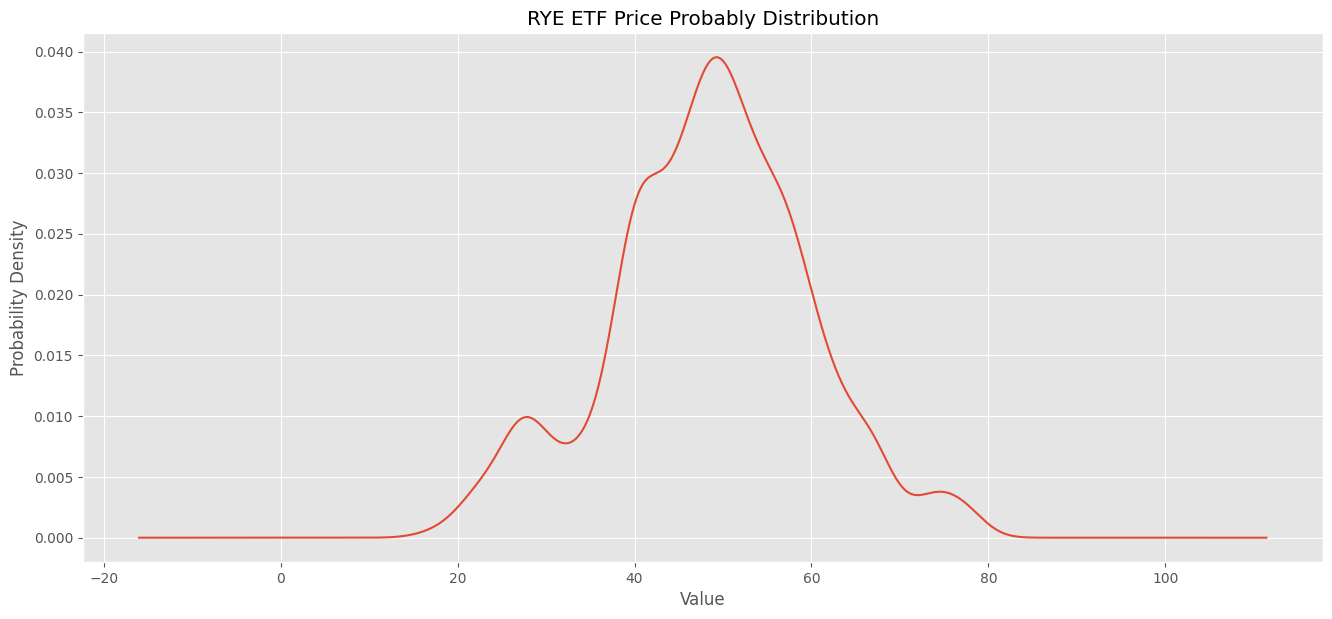

In [5]:
# Plot index price probability density
plot_kde(rye.close, title='RYE ETF Price Probably Distribution', xlabel='Value', ylabel='Probability Density')

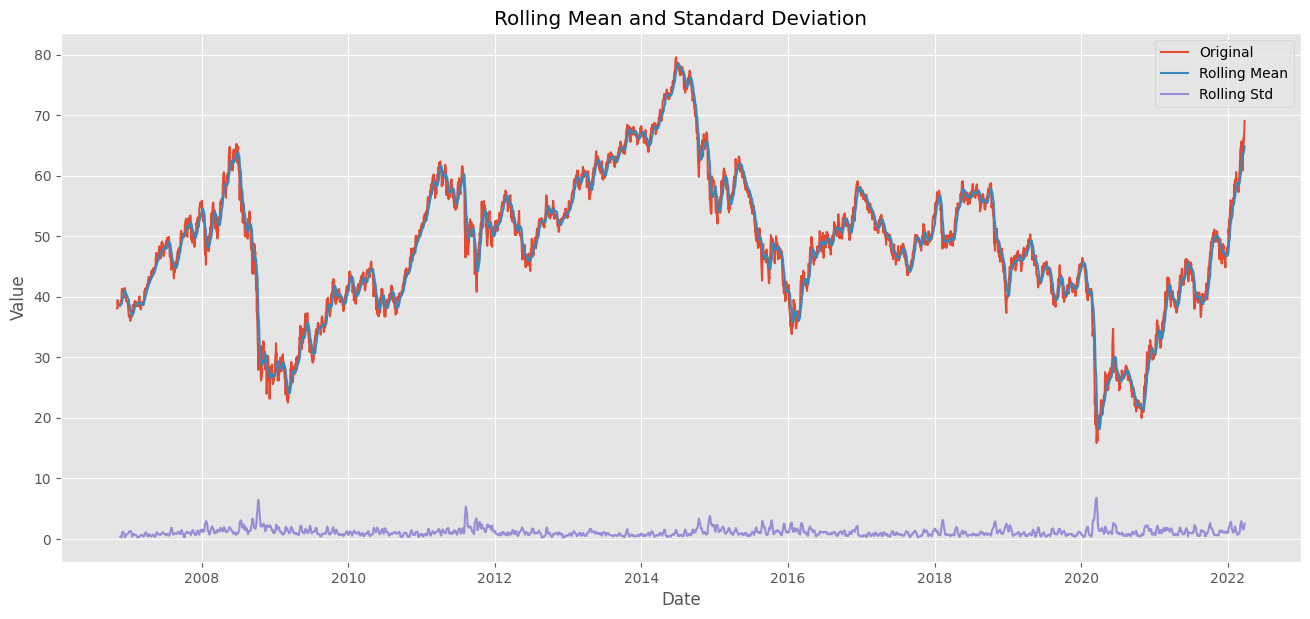

Results of dickey fuller test
Test Statistics                  -2.149988
p-value                           0.224894
No. of lags used                  3.000000
Number of observations used    3868.000000
critical value (1%)              -3.432042
critical value (5%)              -2.862288
critical value (10%)             -2.567168
dtype: float64


In [6]:
# Test and plot staionarity
test_stationarity(rye['close'], xlabel='Date', ylabel='Value')

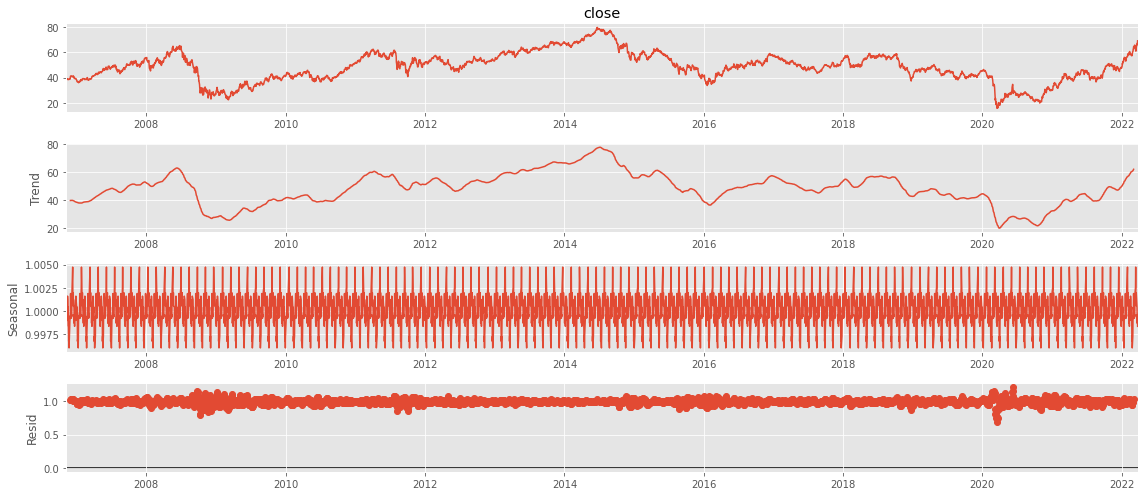

In [7]:
# Plot seasonality
plot_seasonality(rye['close'])

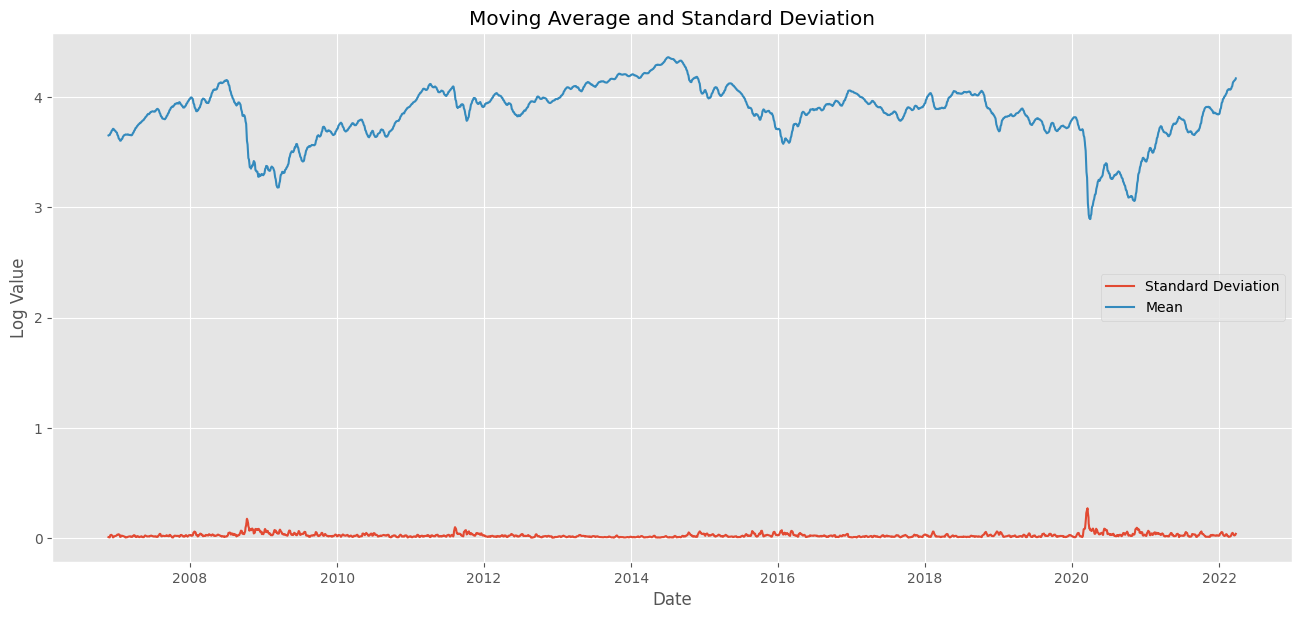

In [8]:
# Not stationary, eliminate trend
index_close_log = np.log(rye['close'])
moving_avg = index_close_log.rolling(12).mean()
std_dev = index_close_log.rolling(12).std()

# Plot rolling statistics:
plot_masd(moving_avg, std_dev)

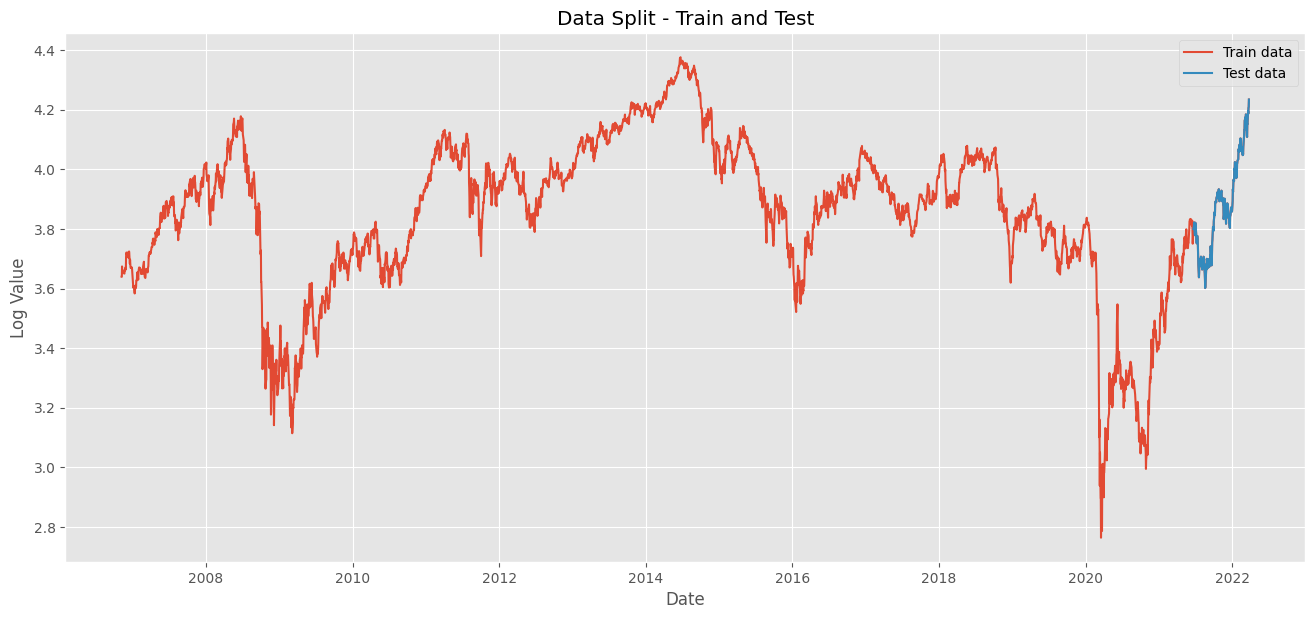

In [9]:
# Set split percentage
train_per = 0.95

#split data into train and training set
train_data = index_close_log[3:int(len(index_close_log)*train_per)]
test_data = index_close_log[int(len(index_close_log)*train_per):]

# Plot train and test split
plot_split(index_close_log, test_data)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17373.433, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17376.232, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-17376.051, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17375.428, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-17375.638, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17373.697, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-17348.837, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-17378.226, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-17377.633, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-17375.693, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-17378.046, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-17377.094, Time=0.48 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.667 seconds
                               SARIMAX Results                  

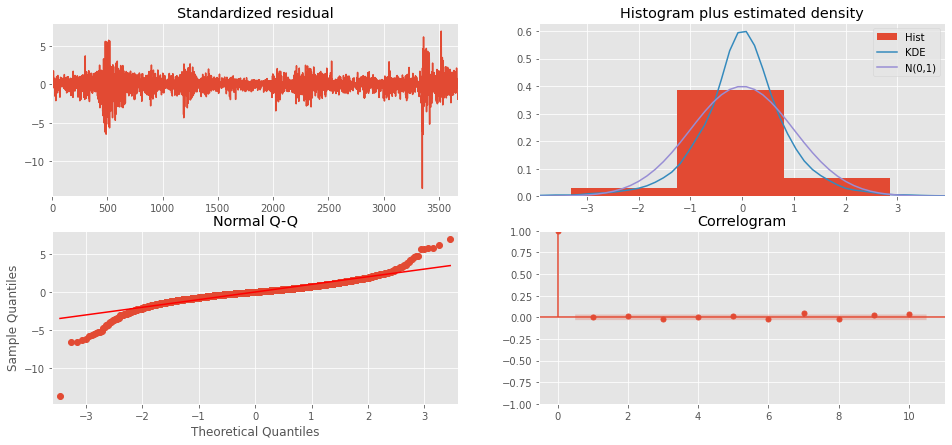

In [10]:
# Auto ARIMA to discover the optimal order for an ARIMA model
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(16, 7))
plt.show()

In [11]:
# Build ARIMA Model
model = ARIMA(train_data, order=(1,1,0))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 3675
Model:                 ARIMA(1, 1, 0)   Log Likelihood                8691.113
Date:                Sun, 27 Mar 2022   AIC                         -17378.226
Time:                        16:32:43   BIC                         -17365.808
Sample:                             0   HQIC                        -17373.806
                               - 3675                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0361      0.009     -3.876      0.000      -0.054      -0.018
sigma2         0.0005   4.17e-06    123.766      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

C:\users\bowen\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\users\bowen\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\users\bowen\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
# Forecast 95% 
fc = fitted.get_forecast(len(test_data), alpha=0.05)
me = fc.predicted_mean
conf = fc.conf_int()
conf.insert(0, me.name, me)
conf = conf.set_axis(test_data.index)
res = conf[:]

res.head()

C:\users\bowen\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,predicted_mean,lower close,upper close
date,,,
2021-06-21,3.751782,3.707252,3.796312
2021-06-22,3.751745,3.689897,3.813592
2021-06-23,3.751746,3.676431,3.827061
2021-06-24,3.751746,3.665032,3.838460
2021-06-25,3.751746,3.654966,3.848526


In [13]:
# Print statistics
## MSE
mse = mean_squared_error(test_data, res['predicted_mean'])
print('Mean Squared Error: ' + str(mse))
## MAE
mae = mean_absolute_error(test_data, res['predicted_mean'])
print('Mean Absolute Error: ' + str(mae))
## RMSE
rmse = math.sqrt(mse)
print('Root Mean Squared Error: ' + str(rmse))
## MAPE
mape = np.mean(np.abs(res['predicted_mean'] - test_data) / np.abs(test_data))
print('Mean Absolute Percentage Error: ' + str(mape))

Mean Squared Error: 0.03977003812957763
Mean Absolute Error: 0.15932726200696418
Root Mean Squared Error: 0.19942426665172328
Mean Absolute Percentage Error: 0.04005797556116035


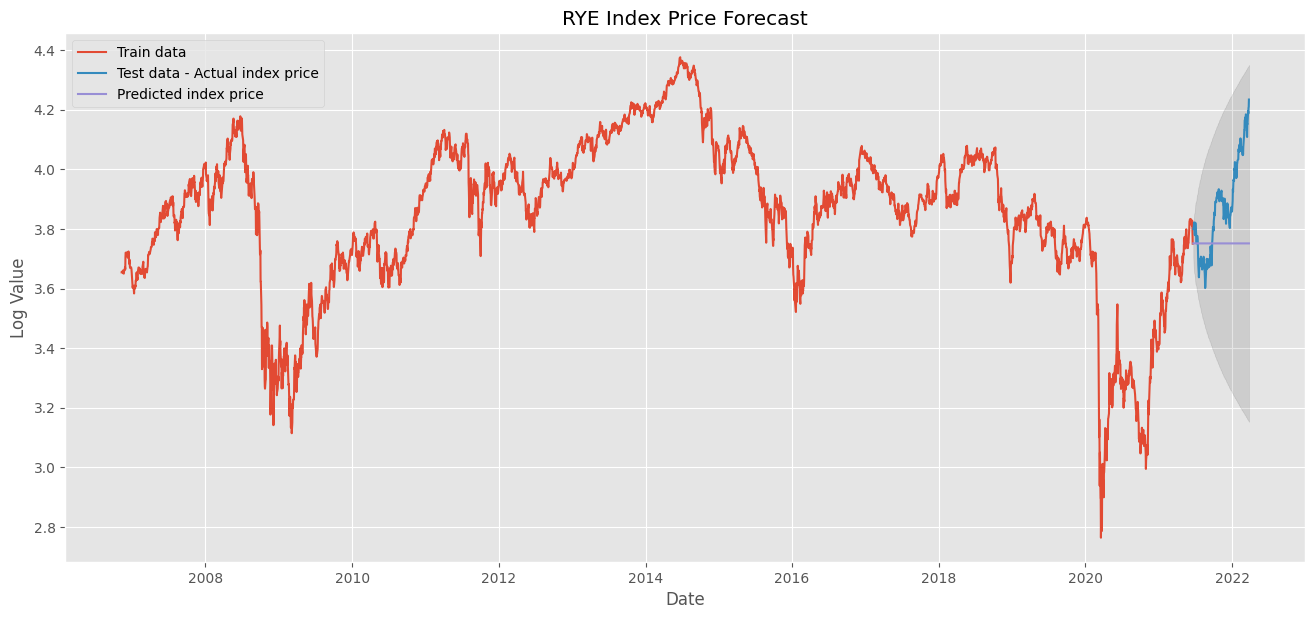

In [14]:
# Plot forecast
plot_forecast(train_data, test_data, res)